## Required Libraries

In [94]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.io import loadmat
import matplotlib.pyplot as plt

## Visualization Settings (Optional)

In [95]:
# plt.rcdefaults()

In [96]:
plt.style.use("seaborn")
plt.rc("figure", figsize=[9, 5])

## Importing Data

In [97]:
train_data = loadmat(file_name="G:\\Datasets\\Anomaly Detection\\anomaly_train.mat")
test_data = loadmat(file_name="G:\\Datasets\\Anomaly Detection\\anomaly_test.mat")

## Helper Functions

In [98]:
def find_best_epsilon(yval, pval):
    """
    Helper Function to find and return the best F1 score
    and Epsilon value for the given feature.
    """
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0

    stepsize = (np.max(pval) - np.min(pval))/1000

    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)

    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0

        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon

        except ZeroDivisionError:
            print("Finished Finding Epsilon...")

    return bestF1, bestEpsilon

## Data Distribution

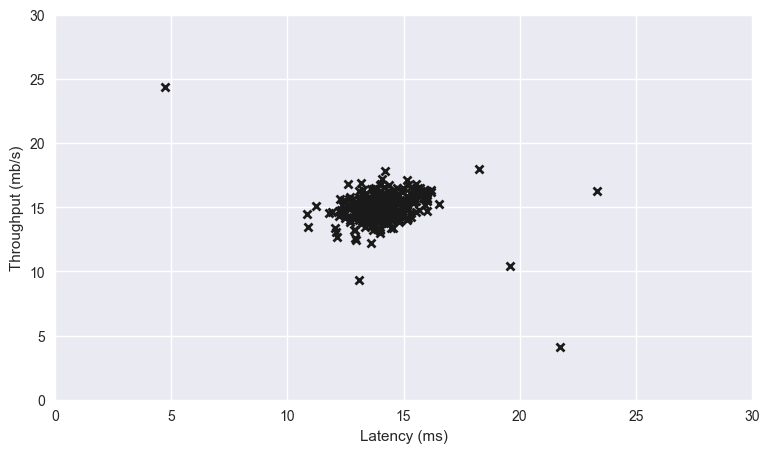

In [99]:
plt.plot(train_data["X"][:, 0], train_data["X"][:, 1], 'bx', mew=2, mec='k', ms=6)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Parameters Estimation

In [100]:
mu = np.mean(train_data["X"], axis=0)
sigma2 = np.std(train_data["X"], axis=0)

## Creating Multivariate Distribution

In [101]:
dist_variable = multivariate_normal(mean=mu)

## Density Estimation

In [102]:
pval_train = dist_variable.pdf(train_data["X"])

In [103]:
pval_train_val = dist_variable.pdf(train_data["Xval"])

## Best Epsilon

In [104]:
best_f1, best_epsilon = find_best_epsilon(train_data["yval"], pval_train_val)
print("Best F1 Score : ", round(best_f1, 2) * 100 , "\nBest Epsilon : ", best_epsilon)

Finished Finding Epsilon...
Best F1 Score :  82.0 
Best Epsilon :  0.0001591449216860312


## Detecting Anomalies

In [105]:
anomaly_idx = [i for i in range(len(pval_train)) if pval_train[i] < best_epsilon]

In [106]:
anomaly_idx

[300, 301, 303, 304, 305, 306]

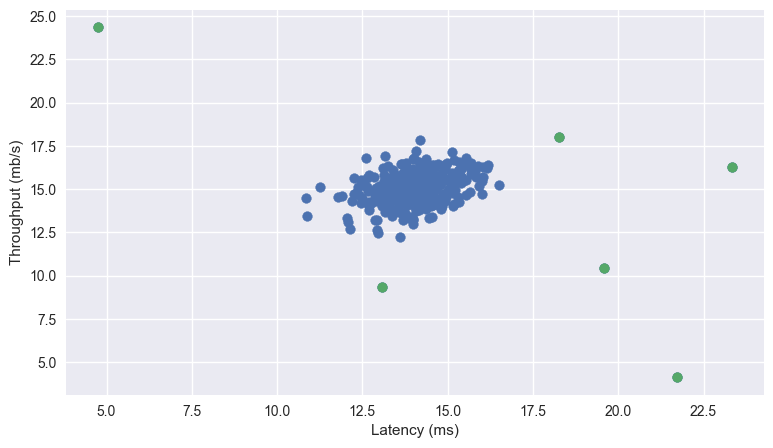

In [107]:
plt.scatter(train_data["X"][:, 0], train_data["X"][:, 1])
plt.scatter(train_data["X"][anomaly_idx, 0], train_data["X"][anomaly_idx, 1])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()